In [1]:
%load_ext autoreload
%autoreload 2

In [122]:
def replace_unet_in_pipeline(pipe, path_to_weights=None, device='cuda'):
    unet = pipe.unet
    tmp = unet.conv_out
    n_noise_pred_channels = unet.conv_out.out_channels

    new_layer =  torch.nn.Conv2d(tmp.in_channels, tmp.out_channels * 2, kernel_size=tmp.kernel_size, padding=tmp.padding, bias=True, dtype=torch.float16) # Add 2 channels to serve for segmentation
    if path_to_weights:
        # load weights
        chkpt = torch.load(path_to_weights)
        new_layer.load_state_dict(chkpt['conv_out_state_dict'])
    else:
        # init weights to pipe weights
        new_layer.weight.data[:tmp.weight.data.shape[0], :, :, :] = tmp.weight.data[:, :, :, :]
    new_layer.to(device=device)
    unet.conv_out = new_layer
    return

import xml.etree.ElementTree as ET
import os

def get_annotations(img_paths, annotations_root):
    voc_classes = {'background' : 'background',
                    'aeroplane' : 'aeroplane',
                    'bicycle' : 'bicycle',
                    'bird' : 'bird',
                    'boat' : 'boat',
                    'bottle' : 'bottle',
                    'bus' : 'bus',
                    'car' : 'car',
                    'cat' : 'cat',
                    'chair' : 'chair',
                    'cow' : 'cow',
                    'diningtable' : 'dining table',
                    'dog' : 'dog',
                    'horse' : 'horse',
                    'motorbike' : 'motorbike',
                    'person' : 'person',
                    'pottedplant' : 'potted plant',
                    'sheep' : 'sheep',
                    'sofa' : 'sofa',
                    'train' : 'train',
                    'tvmonitor' : 'tv monitor'}

    images_names = [os.path.splitext(os.path.basename(path))[0] for path in img_paths]
    xmls_paths = [os.path.join(annotations_root, img_name +'.xml') for img_name in images_names]
    
    annotations = []
    for path in xmls_paths:
        tree = ET.parse(path)
        root = tree.getroot()
        annontation = root.find('object/name')

        annotations += [voc_classes[annontation.text]]

    return annotations

# Sample random pics and get their seg
import os
from os import walk
import random

def diffuse_random_imgs(img_folder, pipe, prompt, strength, guidance,neg_prompt=None, save_path=None):
    N_PICS = 9
    f = next(walk(img_folder), (None, None, []))[2]
    filenames = [os.path.join(img_folder, filename) for filename in f]
    filenames = random.sample(filenames, N_PICS)
    annotations_root = '/disk4/Lev/Projects/diffusion_finetuning/data/Annotations/'
    annotations = get_annotations(filenames, annotations_root)

    fig , ax = plt.subplots(N_PICS, 2,figsize=(15, 40))
    for i, item in enumerate(zip(filenames, annotations)):
        f, annotation = item
        init_image = Image.open(f).convert("RGB").resize((512, 512))
        ax[i, 0].imshow(init_image, aspect='auto')
        ax[i, 0].axis('off')
        
        full_prompt = prompt + ' ' + annotation
        image = pipe(prompt=full_prompt, image=init_image, strength=strength, guidance_scale=guidance, modified_unet=True, segmentation=True).images[0]
        ax[i, 1].imshow(image, aspect='auto')
        ax[i, 1].axis('off')
        ax[i, 1].set_title(full_prompt + ' ' + f)

        if save_path:
            if not os.path.exists(save_path):       
                os.mkdir(save_path)
            init_image.save(os.path.join(save_path, 'original_' + os.path.basename(f)))
            image.save(os.path.join(save_path, os.path.basename(f)))

    plt.show()



In [126]:
def get_good_slices(arr, s_indx=0):
    print(arr.shape)
    slices = []
    for i in range(s_indx, len(arr)):
        if arr[i].max() > 0:
            slices.append(i)
            classes = set(arr[i].flatten().tolist())
            # if len(classes) > 2:
            #     print('Found slice with more than 2 classes', i)
            #     print(classes)
    return slices

## Test Segmentation

In [124]:
import os
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
#@title LOADING MODEL AND MONKEY PATCHING IT
import torch
import numpy as np
from lora_diffusion import monkeypatch_lora, tune_lora_scale
from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img import StableDiffusionImg2ImgPipeline

PATH_PREFIX = '/disk4/Lev/Projects/diffusion_finetuning/output/lits17/w_text/ct_liver_segmentation_good_slices_only_run2'
UNET_WEIGHTS_PATH = os.path.join(PATH_PREFIX, 'unet_seg_weights.pt')
LORA_WEIGHTS_PATH = os.path.join(PATH_PREFIX, 'lora_weight.pt')
LORA_TEXT_WEIGHTS_PATH = os.path.join(PATH_PREFIX,'lora_weight.text_encoder.pt')

model_id = "stabilityai/stable-diffusion-2-1-base"
torch.cuda.empty_cache()
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(model_id, torch_dtype=torch.float16).to('cuda:3')

monkeypatch_lora(pipe.unet, torch.load(LORA_WEIGHTS_PATH))
monkeypatch_lora(pipe.text_encoder, torch.load(LORA_TEXT_WEIGHTS_PATH), target_replace_module=["CLIPAttention"])

tune_lora_scale(pipe.unet, 1.5)
tune_lora_scale(pipe.text_encoder, 1)

replace_unet_in_pipeline(pipe, UNET_WEIGHTS_PATH, device=pipe.device)


Fetching 16 files: 100%|██████████| 16/16 [00:00<00:00, 6037.14it/s]


(677, 512, 512)
(677, 512, 512)
266


100%|██████████| 5/5 [00:00<00:00,  7.67it/s]


decoding seg img


100%|██████████| 5/5 [00:00<00:00,  7.69it/s]


decoding seg img


100%|██████████| 5/5 [00:00<00:00,  7.66it/s]


decoding seg img


100%|██████████| 5/5 [00:00<00:00,  7.01it/s]


decoding seg img


100%|██████████| 5/5 [00:00<00:00,  7.75it/s]


decoding seg img


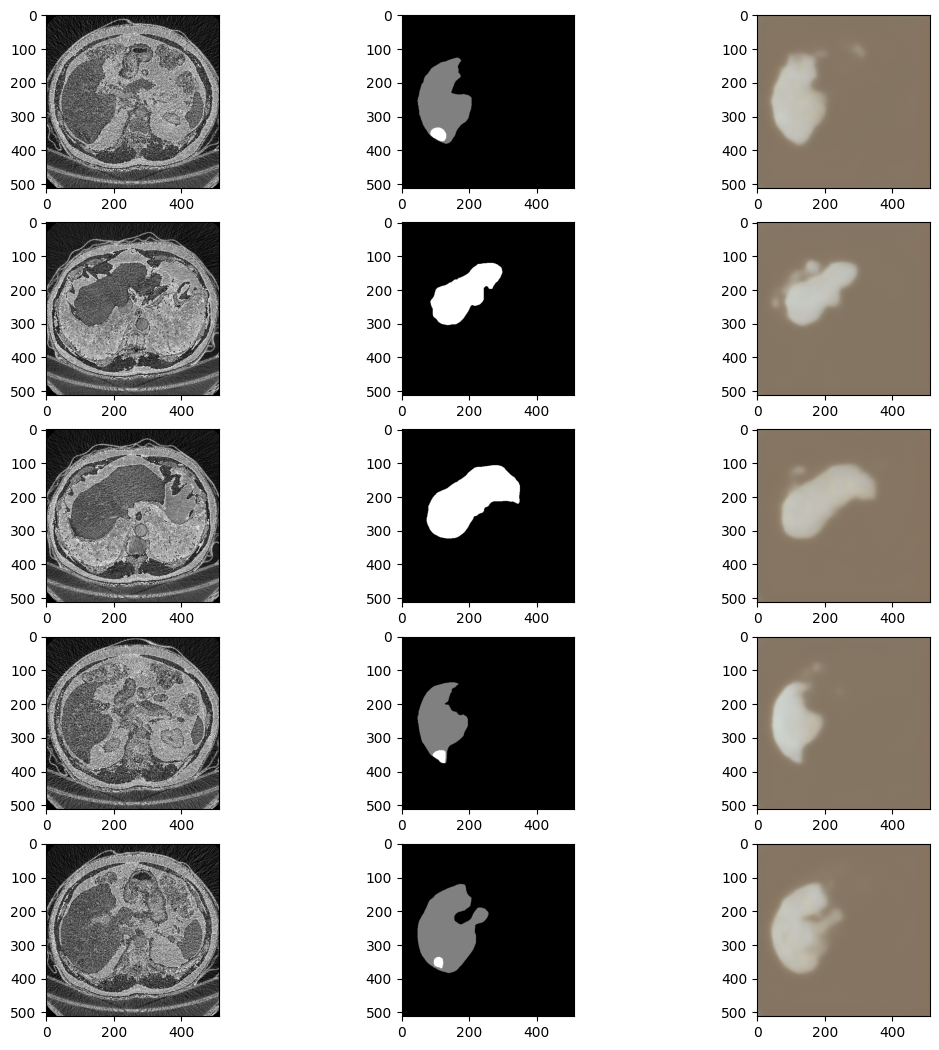

In [149]:
import SimpleITK as sitk
import matplotlib.pyplot as plt
import random
import os
from PIL import Image

n = 102
PATH = '/disk4/Lev/Projects/diffusion_finetuning/data/lits17/train/'
seg_path = os.path.join(PATH,f'segmentation-{n}.nii')
path = os.path.join(PATH,f'volume-{n}.nii')

img = sitk.ReadImage(path, sitk.sitkUInt8)
seg_img = sitk.ReadImage(seg_path, sitk.sitkUInt8)

img = sitk.GetArrayFromImage(img)
seg_img = sitk.GetArrayFromImage(seg_img)
print(img.shape)

slices = get_good_slices(seg_img)
# slices = range(seg_img.shape[0])
print(len(slices))

n_examples = 5
indices = random.sample(slices, n_examples)
fig, ax = plt.subplots(n_examples, 3, figsize=(13,13))
for i, indx in enumerate(indices):
    ax[i, 0].imshow(img[indx], cmap='gray')
    ax[i, 1].imshow(seg_img[indx], cmap='gray')
    in_img = Image.fromarray(img[indx]).convert('RGB')
    output = pipe('segmentation map of liver', in_img, strength=0.1, guidance_scale=12, modified_unet=True, segmentation=True).images[0]
    ax[i, 2].imshow(output)

plt.show()


In [151]:
# function to computs the most different pixels based on euclidean distance
# pixels is a np array of shape (N, 3) where N is the number of 
# returns the 3 pixels with the largest euclidean distance from each other
def get_most_different_pixels(pixels):
    # compute the euclidean distance between all pixels
    dist = np.linalg.norm(pixels[:, None] - pixels, axis=-1)
    # get the 3 pixels with the largest distance from each other
    max_dist = np.max(dist, axis=0)
    max_dist = np.argsort(max_dist)[-3:]
    return pixels[max_dist]

In [160]:
# function that replaces all pixels in array based on how close they are to the 3 inputs pixel values
# array is a np array of shape (H, W, 3)
# for each pixel in img_arr change in to (0,0,0) if its closest to the first pixel in seg_pixels
def convert_to_segmap(img_arr, seg_pixels):
    # Compute the Euclidean distance between each pixel and each input pixel
    distances = np.sqrt(np.sum((img_arr[..., np.newaxis, :] - seg_pixels[np.newaxis, np.newaxis, :, :])**2, axis=-1))

    # Find the indices of the closest input pixel for each pixel
    closest_indices = np.argmin(distances, axis=-1)

    # Create an array to store the result
    result = np.zeros_like(img_arr)

    # Replace each pixel with the corresponding color based on the closest input pixel
    result[closest_indices == 0] = [0, 0, 0]
    result[closest_indices == 1] = [128, 128, 128]
    result[closest_indices == 2] = [255, 255, 255]

    return result

[[159 148 131]
 [159 147 126]
 [202 200 185]]


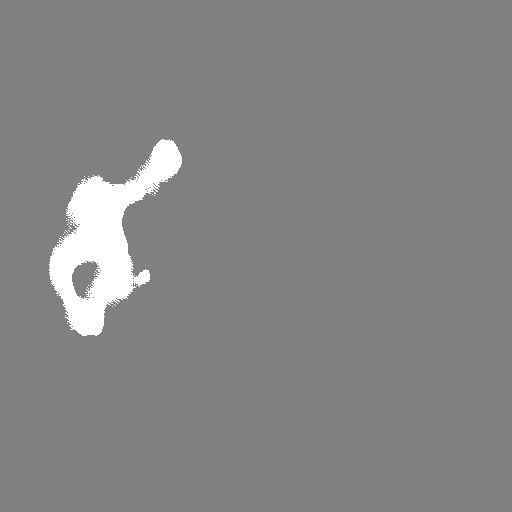

In [162]:
output_arr = np.array(output)
unique_pixels, counts = np.unique(output_arr.reshape(-1,3), axis=0, return_counts=True)
# for pixel, count in zip(unique_pixels, counts):
    # print(pixel, count)

# get two most common pixels
most_common = unique_pixels[np.argsort(counts)[-20:]]
represetive_pixels = get_most_different_pixels(unique_pixels)
print(represetive_pixels)
represetive_pixels = np.array([[0, 0, 0], [128, 128, 128], [255, 255, 255]])
segmap = convert_to_segmap(output_arr, represetive_pixels)
segmap_img = Image.fromarray(segmap)
segmap_img

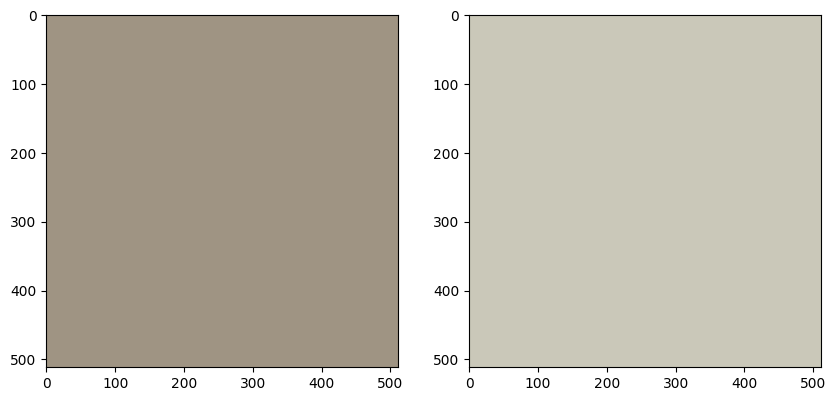

In [155]:
# create image with color (134, 118, 100)
img1 = Image.new('RGB', (512, 512), color = (159, 148, 131))
img2 = Image.new('RGB', (512, 512), color = (202, 200, 185))

# plot img1 and img2 side by side
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(img1)
ax[1].imshow(img2)
plt.show()

In [7]:
import numpy as np

def convert_segmap_to_rgb(seg_arr):
    print(seg_arr.shape)
    seg_arr = seg_arr.astype(np.uint16)
    seg_arr = seg_arr * 128
    seg_arr = Image.fromarray(seg_arr).convert('RGB')

    return seg_arr

In [88]:
def convert_segmap_to_rgb_hard(seg_arr):
    seg_arr = seg_arr.astype(np.uint8)
    # create an empty image with the same shape as the input array
    image = np.zeros((seg_arr.shape[0], seg_arr.shape[1], 3), dtype=np.uint8)
    
    # convert 0 values to (0, 0, 0)
    image[seg_arr == 0] = [0, 0, 0]
    
    # convert 1 values to (128, 128, 128)
    image[seg_arr == 1] = [128, 128, 128]
    
    # convert 2 values to (255, 255, 255)
    image[seg_arr == 2] = [255, 255, 255]
    
    # convert the numpy array to a PIL image
    return Image.fromarray(image)

In [21]:
path = os.path.join(PATH,f'volume-{n}.nii')

img = sitk.ReadImage(path, sitk.sitkUInt8)
img_arr = sitk.GetArrayFromImage(img)[337].astype(np.uint16)


In [ ]:
seg_img = Image.fromarray(img_arr).convert('RGB')

seg_arr = np.array(seg_img)
print(seg_arr.shape)
print(set(seg_arr.flatten().tolist()))
seg_arr = seg_arr.reshape(-1,3)
unique_pixels = np.unique(seg_arr, axis=0, return_counts=False)
print(unique_pixels)

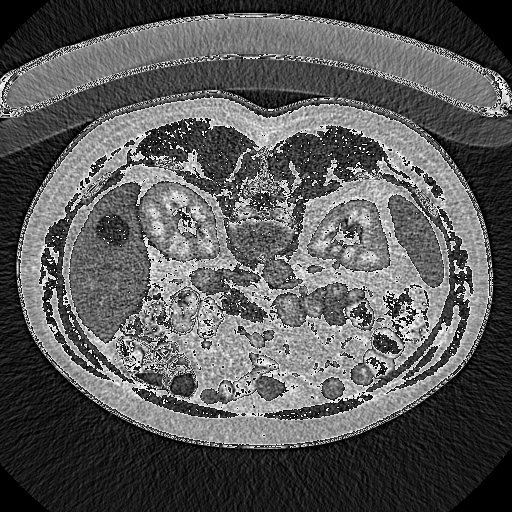

In [19]:
seg_img

In [9]:
import os
import fnmatch
import pickle

def list_files(directory, substring):
    files = []
    for root, dir, filenames in os.walk(directory):
        for filename in fnmatch.filter(filenames, substring + '*'):
            files.append(os.path.join(root, filename))
    return files

seg_files = list_files(PATH, 'segmentation')
# print(len(seg_files), '\n', len(vol_files))

seg_files_w_good_slices = {}
for path in seg_files:
    img = sitk.ReadImage(path)
    img_arr = sitk.GetArrayFromImage(img)
    good_slices = get_good_slices(img_arr)
    seg_files_w_good_slices[path] = good_slices

KeyboardInterrupt: 

In [7]:
seg_files_w_good_slices

NameError: name 'seg_files_w_good_slices' is not defined

### Test LITS17 DS

In [6]:
ct_path = '/disk4/Lev/Projects/diffusion_finetuning/data/lits17/train/volume-102.nii'
seg_path = '/disk4/Lev/Projects/diffusion_finetuning/data/lits17/train/segmentation-102.nii'

ct = sitk.ReadImage(ct_path, sitk.sitkUInt8)
seg = sitk.ReadImage(seg_path, sitk.sitkUInt8)

ct_array = sitk.GetArrayFromImage(ct)
seg_array = sitk.GetArrayFromImage(seg)

In [37]:
seg_img = Image.fromarray(seg_array*127)
ct_img = Image.fromarray(ct_array)

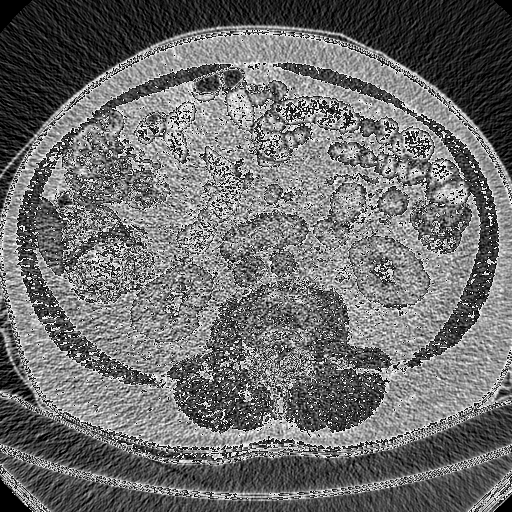

In [38]:
ct_img

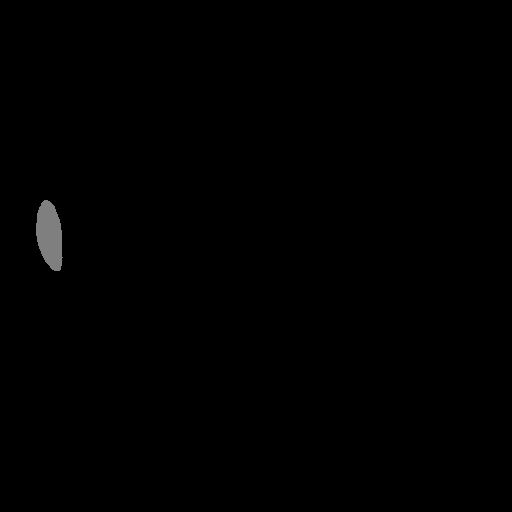

In [36]:
seg_img

In [19]:
good_slices = get_good_slices(seg_array)
good_slices

[322,
 323,
 324,
 372,
 373,
 374,
 375,
 376,
 377,
 378,
 379,
 380,
 381,
 382,
 383,
 384,
 385,
 386,
 387,
 388,
 389,
 390,
 391,
 392,
 393,
 394,
 395,
 396,
 397,
 398,
 399,
 400,
 401,
 402,
 403,
 404,
 405,
 406,
 407,
 408,
 409,
 410,
 411,
 412,
 413,
 414,
 415,
 416,
 417,
 418,
 419,
 420,
 421,
 422,
 423,
 424,
 425,
 426,
 427,
 428,
 429,
 430,
 431,
 432,
 433,
 434,
 435,
 436,
 437,
 438,
 439,
 440,
 441,
 442,
 443,
 444,
 445,
 446,
 447,
 448,
 449,
 450,
 451,
 452,
 453,
 454,
 455,
 456,
 457,
 458,
 459,
 460,
 461,
 462,
 463,
 464,
 465,
 466,
 467,
 468,
 469,
 470,
 471,
 472,
 473,
 474,
 475,
 476,
 477,
 478,
 479,
 480,
 481,
 482,
 483,
 484,
 485,
 486,
 487,
 488,
 489,
 490,
 491,
 492,
 493,
 494,
 495,
 496,
 497,
 498,
 499,
 500,
 501,
 502,
 503,
 504,
 505,
 506,
 507,
 508,
 509,
 510,
 511,
 512,
 513,
 514,
 515,
 516,
 517,
 518,
 519,
 520,
 521,
 522,
 523,
 524,
 525,
 526,
 527,
 528,
 529,
 530,
 531,
 532,
 533,
 534,
 535

In [56]:
def convert_tensor_to_img(tensor, normalized=False):
    if normalized:
        arr = np.array(tensor*255, dtype=np.uint8)
    else:
        arr = np.array(tensor, dtype=np.uint8)
    print(arr.shape)
    arr = np.moveaxis(arr, [0, 1, 2], [2, 0, 1])
    print(arr.shape)
    if arr.shape[2] == 1:
        arr = arr.squeeze(2)
    img = Image.fromarray(arr)
    return img 

In [38]:
def numpy_to_pil(images):
    """
    Convert a numpy image or a batch of images to a PIL image.
    """
    if images.ndim == 3:
        images = images[None, ...]
    images = (images * 255).round().astype("uint8")
    if images.shape[-1] == 1:
        # special case for grayscale (single channel) images
        pil_images = [Image.fromarray(image.squeeze(), mode="L") for image in images]
    else:
        pil_images = [Image.fromarray(image) for image in images]

    return pil_images


ct shape:torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
(262144, 3)
unique pixels: [[  0   0   0]
 [  0   0 128]
 [  0 128   0]
 [  0 128 128]
 [128   0   0]
 [128   0 128]
 [128 128   0]
 [128 128 128]
 [128 128 255]
 [128 255 128]
 [128 255 255]
 [255 128   0]
 [255 128 128]
 [255 255 128]
 [255 255 255]] 

 counts: [239263    247      1    249    247      3    247  18811    139      4
    135      2    137    135   2524]
torch.Size([3, 512, 512])   torch.Size([3, 512, 512])
(3, 512, 512)
(512, 512, 3)
(3, 512, 512)
(512, 512, 3)


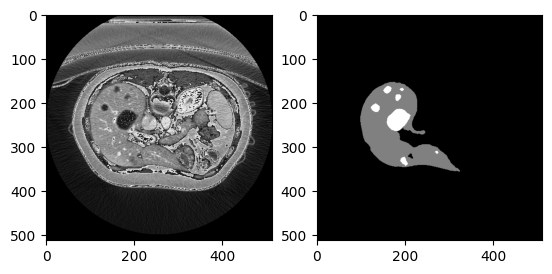

In [121]:
from training_scripts.LITS17Dataset import LITS17Dataset
from transformers import CLIPTokenizer
import os
import matplotlib.pyplot as plt

ct_dir = '/disk4/Lev/Projects/diffusion_finetuning/data/lits17/train'
vol_pkl = os.path.join(ct_dir, 'lits_train_vol_files_good_slices.pickle')
seg_pkl = os.path.join(ct_dir, 'lits_train_seg_files_good_slices.pickle')
lits17ds = LITS17Dataset(ct_dir,
                         ct_dir,
                         prompt='segmentation map of liver',
                         path_slices_for_segmap=seg_pkl,
                         path_slices_for_vol=vol_pkl)

example = lits17ds[1000]
ct = example['instance_image'] # torch tensor
print(f'ct shape:{ct.shape}')
seg = example['instance_segmap_image'] # torch tensor
print(seg.shape)
# print unique values in seg
seg_np_arr = seg.numpy().reshape(-1,3)
print(seg_np_arr.shape)
unique_pixels, counts = np.unique(seg_np_arr, axis=0, return_counts=True)
print('unique pixels:', unique_pixels,'\n\n', 'counts:', counts)


print(ct.shape, ' ', seg.shape)
ct = convert_tensor_to_img(ct, True)
seg = convert_tensor_to_img(seg, False)

fig, ax = plt.subplots(1, 2)
ax[0].imshow(ct, cmap='gray')
ax[1].imshow(seg)
plt.show()

In [25]:
# write code to automatically reload modules
%load_ext autoreload
%autoreload 2

In [40]:
# Makes sure that the lists are aligned

lst_vol = lits17ds.ct_list_w_slices
lst_seg = lits17ds.seg_list_w_slices

i = 0
for vol, seg in zip(lst_vol, lst_seg):
    if vol[0] != seg[0].replace('segmentation', 'volume') or vol[1] != seg[1]:
        print(vol, '\n', seg, '\n\n')